### THE CASE STUDY

We are collaborating with Lending Club, a finance company specializing in providing various types of loans to urban customers. When the company receives a loan application, it must decide whether to approve the loan based on the applicant’s profile. Two types of risks are associated with the company's decision:

- If the applicant is likely to repay the loan, not approving the loan results in a loss of business for the company.
- If the applicant is likely to default on the loan, approving the loan may lead to a financial loss for the company.


**Business Objective:**

The primary objective is to analyze past loan applicant data to identify patterns that predict the likelihood of default. By understanding these patterns through Exploratory Data Analysis (EDA), the company aims to make informed decisions such as denying loans, reducing loan amounts, or lending to risky applicants at higher interest rates. This analysis will help Lending Club minimize financial losses and optimize their loan approval process.

### DATA PREPROCESSING

#### ignore warnings

In [87]:
import warnings
warnings.filterwarnings('ignore')

#### Import required lib

In [88]:
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
%matplotlib inline


#### Loading and reviewing dataset

In [89]:
df= pd.read_csv("loan.csv")

# To find the number of rows and columns
rows, columns = df.shape
print(f'Dataset has {rows} rows and {columns} columns.')

print("-----Data Spec--------\n")
df.info()


print("\n-----Sample--------")
df.head()

Dataset has 39717 rows and 111 columns.
-----Data Spec--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB

-----Sample--------


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


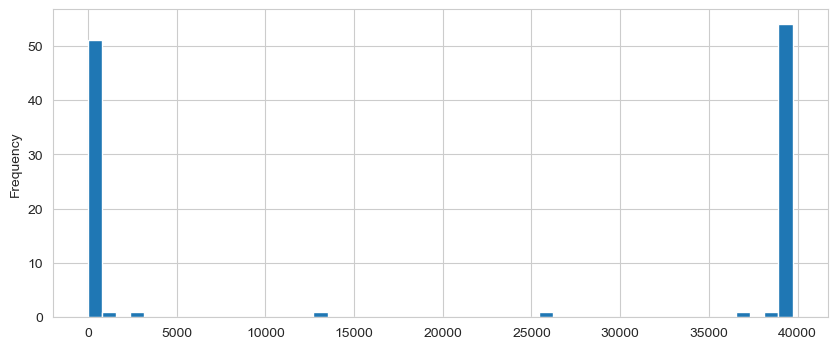

In [90]:
# making a local copy of imported data
loan_df = df.copy() 

#We have observed Null NaN values
#Let us explore
c = loan_df.isnull().sum()
c.plot(kind='hist', bins=50, figsize = (10,4))
plt.show()

In [91]:
c.loc[(c.values > 3000) & (c.values < df.shape[0])].sort_values()

desc                      12940
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

#### Clean Up The Data

In [92]:
print(f'Number of columns in original data: {loan_df.shape[1]}')
loan_df.drop(columns=list(c[c.values > 3000].index), inplace=True)
print(f'Number of columns after removing columns with more than 3000 null val: {loan_df.shape[1]}')

Number of columns in original data: 111
Number of columns after removing columns with more than 3000 null val: 53


In [93]:
# Removing columns with unique single values
for feature in loan_df.columns:
    if loan_df[feature].dtype == 'O'and feature != 'loan_status':
        if len(loan_df[feature].unique())==1:
            del loan_df[feature]
            
    elif len(loan_df[feature].unique())==1 :
        del loan_df[feature]
        
# Data after removing the features
print(f'Number of columns in processed data: {loan_df.shape[1]}')

Number of columns in processed data: 47


In [94]:
print(loan_df.columns.values)

['id' 'member_id' 'loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'term'
 'int_rate' 'installment' 'grade' 'sub_grade' 'emp_title' 'emp_length'
 'home_ownership' 'annual_inc' 'verification_status' 'issue_d'
 'loan_status' 'url' 'purpose' 'title' 'zip_code' 'addr_state' 'dti'
 'delinq_2yrs' 'earliest_cr_line' 'inq_last_6mths' 'open_acc' 'pub_rec'
 'revol_bal' 'revol_util' 'total_acc' 'out_prncp' 'out_prncp_inv'
 'total_pymnt' 'total_pymnt_inv' 'total_rec_prncp' 'total_rec_int'
 'total_rec_late_fee' 'recoveries' 'collection_recovery_fee'
 'last_pymnt_d' 'last_pymnt_amnt' 'last_credit_pull_d'
 'collections_12_mths_ex_med' 'chargeoff_within_12_mths'
 'pub_rec_bankruptcies' 'tax_liens']


Considering our usecase,i.e finding the risk factor, some fields are not applicable. Therefore, let us drop all these columns

In [95]:
# List of features to remove
rmv_lst = ['id', 'member_id', 'url', 
           'title', 'emp_title', 
           'out_prncp_inv', 'zip_code', 'last_credit_pull_d', 
           'total_rec_late_fee', 'chargeoff_within_12_mths', 'delinq_2yrs', 'last_pymnt_d', 'revol_bal', 
           'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_prncp', 'collection_recovery_fee', 
           'last_pymnt_amnt','recoveries', 'collections_12_mths_ex_med', 
           'tax_liens','earliest_cr_line']
loan_df.drop(columns=rmv_lst, inplace=True)
loan_df.shape

(39717, 24)

In [96]:
loan_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,total_acc,total_pymnt_inv,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39020.000000
mean,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.869200,9.294408,0.055065,22.088828,11567.149118,0.043260
std,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,1.070219,4.400282,0.237200,11.401709,8942.672613,0.204324
min,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,6.000000,0.000000,13.000000,5112.310000,0.000000
50%,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,1.000000,9.000000,0.000000,20.000000,9287.150000,0.000000
75%,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,1.000000,12.000000,0.000000,29.000000,15798.810000,0.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,8.000000,44.000000,4.000000,90.000000,58563.680000,2.000000


### Feature Engineering

***Description of Features***

---
 - `annual_inc`:	The self-reported annual income provided by the borrower during registration.

 - `dti`	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

 - `emp_length`	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

 - `funded_amnt`	The total amount committed to that loan at that point in time.

 - `funded_amnt_inv`	The total amount committed by investors for that loan at that point in time.

 - `grade`	LC assigned loan grade

 - `home_ownership`	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
id	A unique LC assigned ID for the loan listing.

 - `inq_last_12m`	Number of credit inquiries in past 12 months

 - `nq_last_6mths`	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

 - `installment`	The monthly payment owed by the borrower if the loan originates.

 - `int_rate`	Interest Rate on the loan

 - `issue_d`	The month which the loan was funded
 
 - `loan_amnt`	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

 - `loan_status`	Current status of the loan

 - `open_acc`	The number of open credit lines in the borrower's credit file.

 - `pub_rec`	Number of derogatory public records

 - `pub_rec_bankruptcies`	Number of public record bankruptcies

 - `purpose`	A category provided by the borrower for the loan request. 

 - `revol_util`	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

 - `sub_grade`	LC assigned loan subgrade

 - `term`	The number of payments on the loan. Values are in months and can be either 36 or 60.

 - `total_acc`	The total number of credit lines currently in the borrower's credit file

 - `total_pymnt_inv`	Payments received to date for portion of total amount funded by investors

 - `verification_status`	Indicates if income was verified by LC, not verified, or if the income source was verified


---


Considering **Loan_Status**

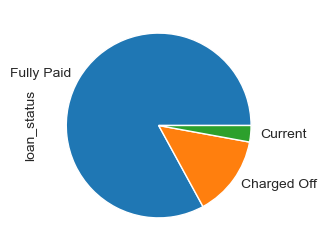

In [97]:
# Creating plot
fig = plt.figure(figsize=(5, 3))
# plt.pie(loan_df, labels=cars)
loan_df['loan_status'].value_counts(normalize=True).plot.pie()
# show plot
plt.show()

The data with loan status "Current" doesnt give any insights for our analysis  to consider. So dropping this data makes sense

In [98]:
loan_df = loan_df[~(loan_df['loan_status'] == 'Current')]
loan_df.shape

(38577, 24)

___
Considering **Term**

In [99]:
loan_df['term'].value_counts()

 36 months    29096
 60 months     9481
Name: term, dtype: int64

---
Considering **int_rate**

In [100]:
loan_df['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

<AxesSubplot:>

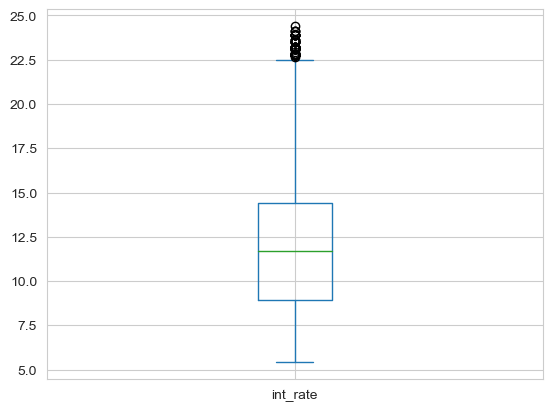

In [101]:
#Let's remve %
loan_df['int_rate'] = loan_df['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
loan_df['int_rate'].plot.box()

**Observation:** There are some outlier values in int_rate column

---
Considering **grade** and **sub_grade**

In [102]:
loan_df['grade'].value_counts()

B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64

In [103]:
loan_df['sub_grade'].value_counts()

A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: sub_grade, dtype: int64

Considering **emp_length**

In [104]:
loan_df['emp_length'].unique()
loan_df['emp_length'].isnull().sum()

1033

Considering **home_ownership**

In [105]:
loan_df['home_ownership'].value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

Considering **verification_status**

In [106]:
loan_df['verification_status'].value_counts()

Not Verified       16694
Verified           12206
Source Verified     9677
Name: verification_status, dtype: int64

Considering **issue_d** (The month which the loan was funded)

In [107]:
loan_df['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [108]:
m, y = loan_df['issue_d'].str.split('-').str
loan_df['issue_y'] = pd.to_numeric(y)
loan_df['issue_m'] = m
loan_df.drop(columns=['issue_d'], inplace=True)

In [109]:
loan_df['issue_y'].value_counts()

11    20516
10    11532
9      4716
8      1562
7       251
Name: issue_y, dtype: int64

In [110]:
loan_df['issue_m'].value_counts()

Dec    4215
Nov    4006
Oct    3761
Sep    3498
Aug    3388
Jul    3351
Jun    3180
May    2919
Apr    2831
Mar    2691
Jan    2379
Feb    2358
Name: issue_m, dtype: int64

Considering **purpose**

In [111]:
loan_df['purpose'].value_counts()

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64

Considering **revol_util**

In [112]:
loan_df['revol_util'].describe()

count     38527
unique     1088
top          0%
freq        954
Name: revol_util, dtype: object

Exploratory Data Analysis
---

### UNIVARIATE ANALYSIS

  - `loan_amnt`	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
  
 - `funded_amnt`	The total amount committed to that loan at that point in time.

 - `funded_amnt_inv`	The total amount committed by investors for that loan at that point in time.

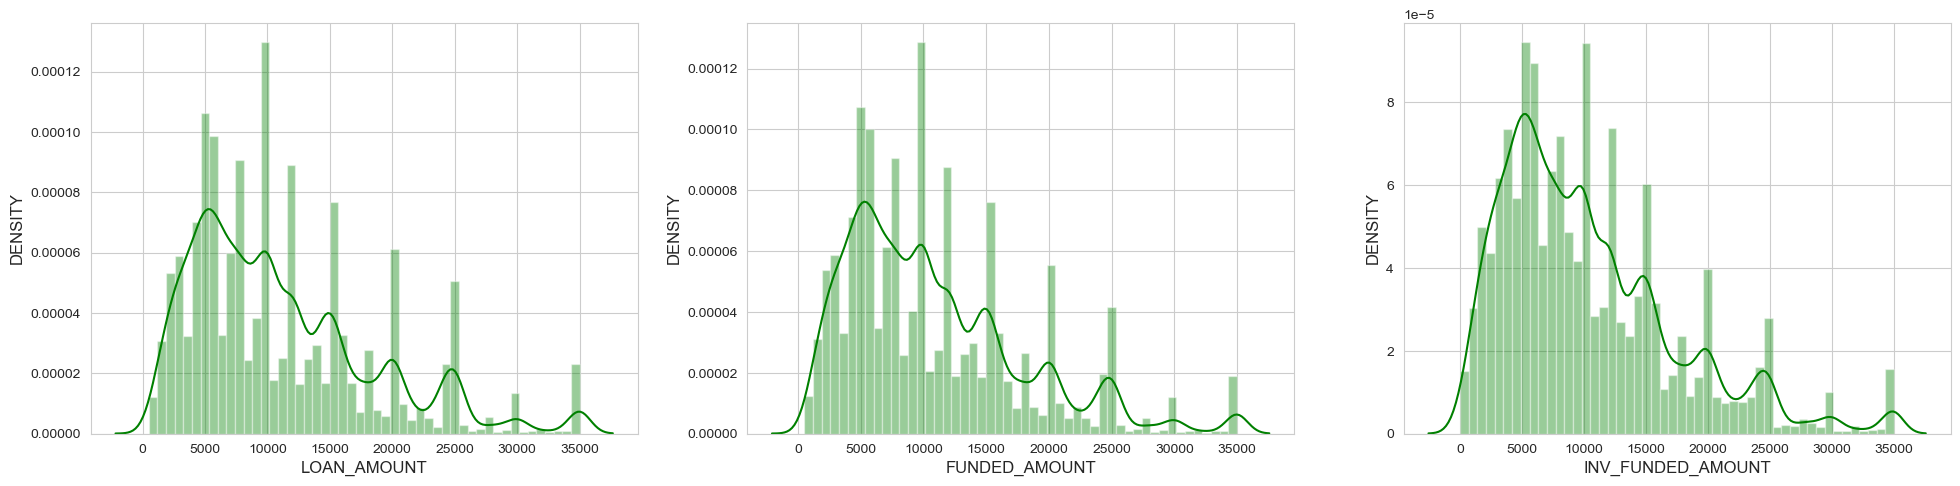

In [113]:
# Creating plots
fig = plt.figure(figsize=(24,40))
spec = fig.add_gridspec(6,3)
spec.update(wspace=0.2, hspace=0.3)
sec_01 = fig.add_subplot(spec[0,0])
sec_02 = fig.add_subplot(spec[0,1])
sec_03 = fig.add_subplot(spec[0,2])

# Adding color preference
bg_color = 'white'
for selection in [fig, sec_01, sec_02, sec_03]:
    selection.set_facecolor(bg_color)

# Plotting the graph
sec = [sec_01, sec_02, sec_03]

cnt = 0
for feature in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']:
    sns.distplot(loan_df[feature], ax=sec[cnt], color='green')
    sec[cnt].set_ylabel('DENSITY' , fontsize=12)
    cnt+=1
    
sec_01.set_xlabel('LOAN_AMOUNT' , fontsize=12)
sec_02.set_xlabel('FUNDED_AMOUNT' , fontsize=12)
sec_03.set_xlabel('INV_FUNDED_AMOUNT' , fontsize=12)

plt.show()

**OBSERVATION**
 - Density distribution for all the three features are similar. Hence, we can proceed forward to anlayse with any of the feature.
 - Based on the nature by description we will proceed forward with "loan_amnt".

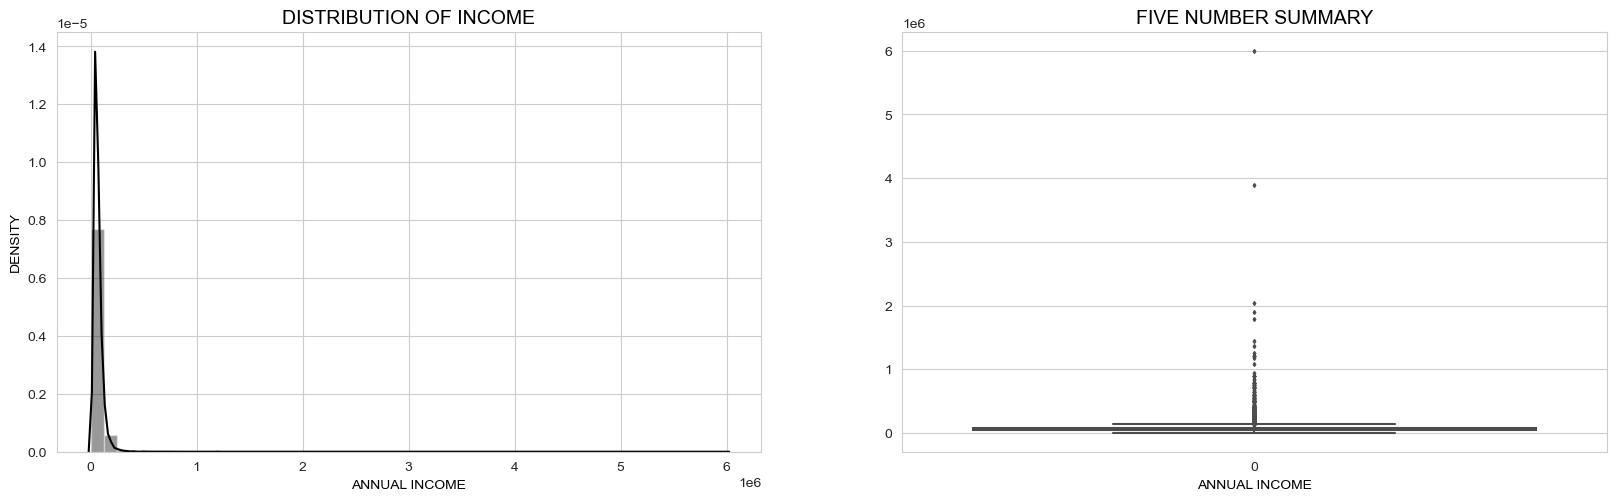

In [114]:
# Distribution plot and outlier plot
# Distribution plot
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
viz = sns.distplot(loan_df['annual_inc'], color='black')
viz.set_title('DISTRIBUTION OF INCOME',fontsize=14,color='black')
viz.set_ylabel('DENSITY',fontsize =10,color = 'black')
viz.set_xlabel('ANNUAL INCOME',fontsize =10,color = 'black') 

# Outlier plot
plt.subplot(2,2,2)
viz = sns.boxplot(loan_df['annual_inc'], color='red',fliersize=2)
viz.set_title('FIVE NUMBER SUMMARY',fontsize=14,color='black')
viz.set_xlabel('ANNUAL INCOME',fontsize =10,color = 'black')
plt.show()

In [115]:
# Numerical summary
print('Numerical Summary: ')
print('Mean:', loan_df['annual_inc'].mean())
print('Median:', loan_df['annual_inc'].quantile(0.5))
print('90% Data', loan_df['annual_inc'].quantile(0.9))
print('99% Data:', loan_df['annual_inc'].quantile(0.99))
print('100% Data:', loan_df['annual_inc'].quantile(1))

Numerical Summary: 
Mean: 68777.97368120901
Median: 58868.0
90% Data 115000.0
99% Data: 234143.99999999878
100% Data: 6000000.0


In [116]:
loan_df['int_rate'] = loan_df['int_rate'].replace('[\%]', '', regex=True).astype(float)

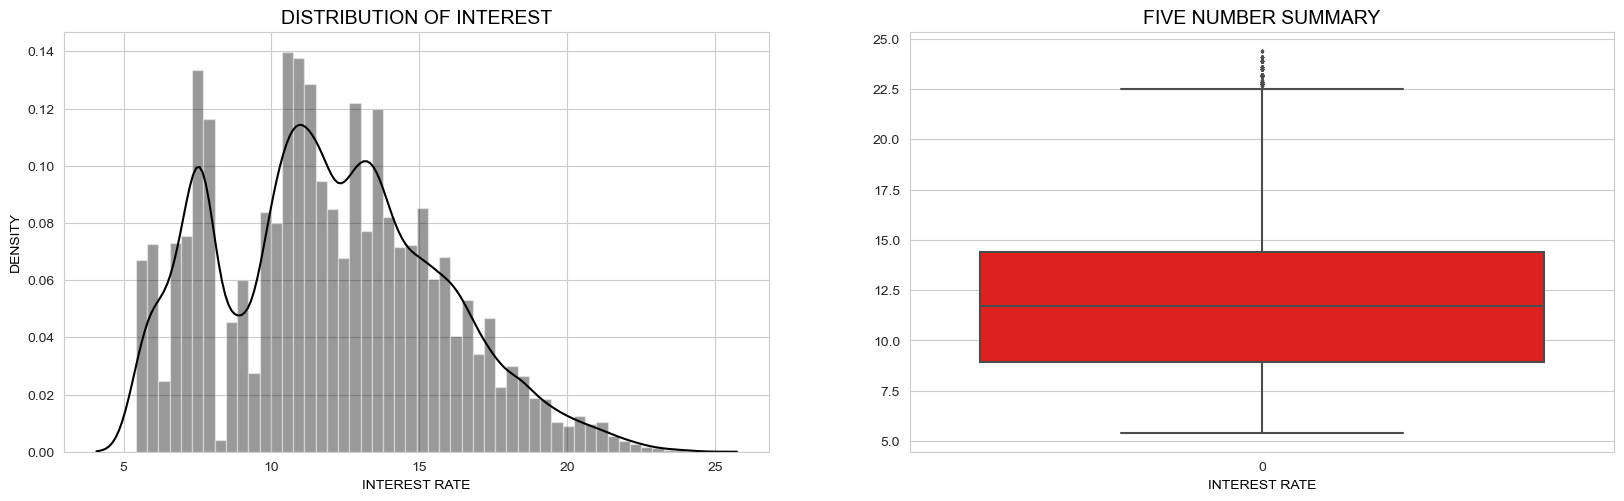

In [117]:
# Distribution plot and outlier plot
# Distribution plot
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
viz = sns.distplot(loan_df['int_rate'], color='black')
viz.set_title('DISTRIBUTION OF INTEREST',fontsize=14,color='black')
viz.set_ylabel('DENSITY',fontsize =10,color = 'black')
viz.set_xlabel('INTEREST RATE',fontsize =10,color = 'black') 

# Outlier plot
plt.subplot(2,2,2)
viz = sns.boxplot(loan_df['int_rate'], color='red',fliersize=2)
viz.set_title('FIVE NUMBER SUMMARY',fontsize=14,color='black')
viz.set_xlabel('INTEREST RATE',fontsize =10,color = 'black')
plt.show()

In [118]:
# Numerical summary
print('Numerical Summary: ')
print('Average interest rate:',np.round(loan_df['int_rate'].mean()),'%')
print('Interest rate @75 percentile:',np.round(loan_df['int_rate'].quantile(0.75)),'%')
print('Interest rate @90 percentile:',np.round(loan_df['int_rate'].quantile(0.9)),'%')
print('Interest rate @99 percentile:',np.round(loan_df['int_rate'].quantile(0.99)),'%')

Numerical Summary: 
Average interest rate: 12.0 %
Interest rate @75 percentile: 14.0 %
Interest rate @90 percentile: 17.0 %
Interest rate @99 percentile: 21.0 %


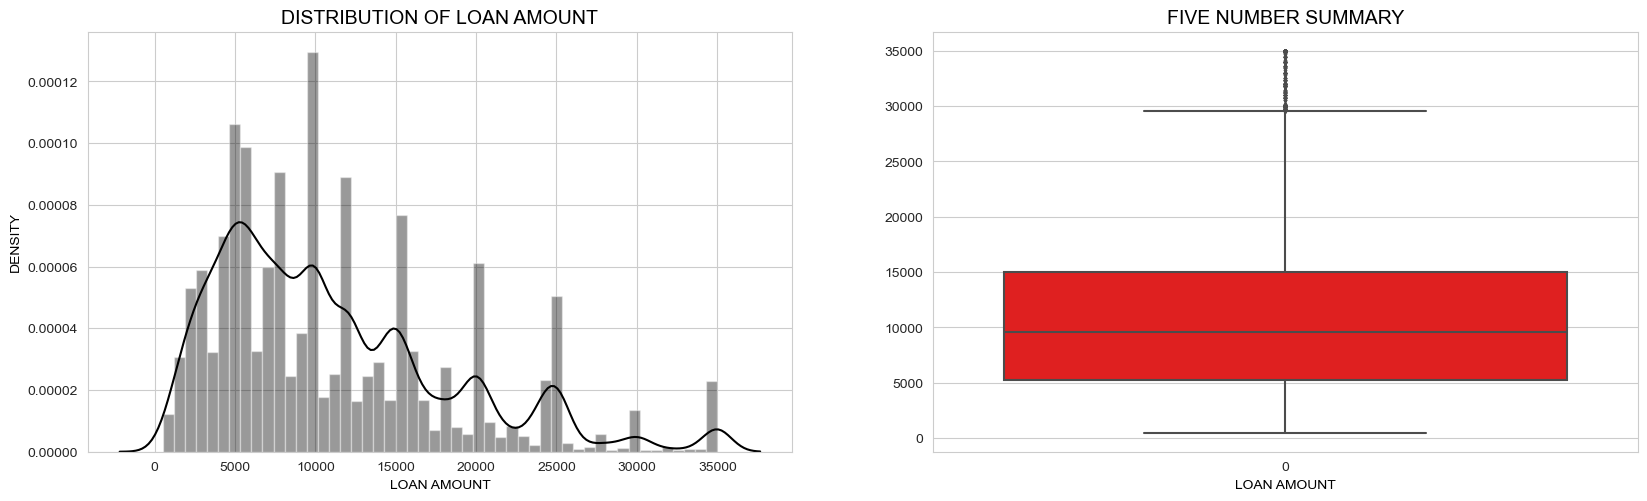

In [119]:
# Distribution plot and outlier plot
# Distribution plot
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
viz = sns.distplot(loan_df['loan_amnt'], color='black')
viz.set_title('DISTRIBUTION OF LOAN AMOUNT',fontsize=14,color='black')
viz.set_ylabel('DENSITY',fontsize =10,color = 'black')
viz.set_xlabel('LOAN AMOUNT',fontsize =10,color = 'black')   

# Outlier plot
plt.subplot(2,2,2)
viz = sns.boxplot(loan_df['loan_amnt'], color='red',fliersize=2)
viz.set_title('FIVE NUMBER SUMMARY',fontsize=14,color='black')
viz.set_xlabel('LOAN AMOUNT',fontsize =10,color = 'black')  
plt.show()

**Correlation Matrix**

Now let us understand how the variables are related to each other. 

In [120]:
# changing the loan_status to a numeric variable, assign 1 for defaulted loans and 0 for paid off ones
loan_df['loan_status_num'] = loan_df['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [121]:
loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,total_pymnt_inv,pub_rec_bankruptcies,issue_y,issue_m,loan_status_num
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,1,3,0,83.70%,9,5833.84,0.0,11,Dec,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,5,3,0,9.40%,4,1008.71,0.0,11,Dec,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,2,2,0,98.50%,10,3005.67,0.0,11,Dec,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,1,10,0,21%,37,12231.89,0.0,11,Dec,0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,...,3,9,0,28.30%,12,5632.21,0.0,11,Dec,0


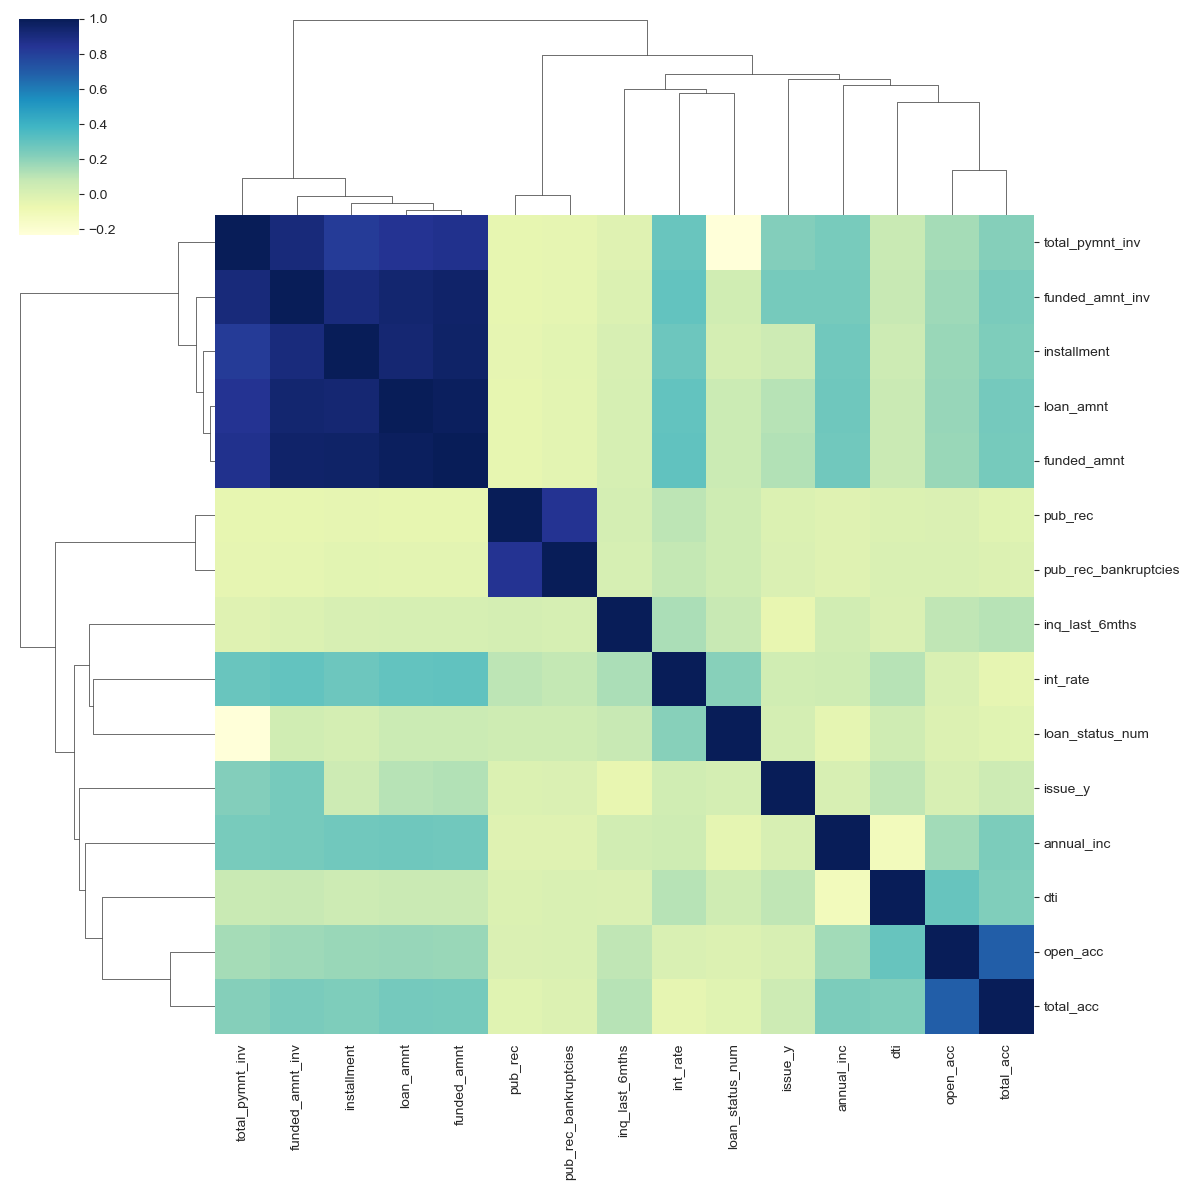

In [122]:
sns.set_style("whitegrid")
sns.clustermap(data=loan_df.corr(), cmap='YlGnBu', figsize=(12,12))
plt.show()

**Observations**
 - `loan_amnt`, `funded_amnt`, `funded_amnt_inv` and `installment` have huge correlation
 - `pub_rec` & `pub_rec_bankrupcies` 
 - `open_acc` & `total_acc` are correlated.


In [123]:
def PercentileCut (*, data=loan_df, column, trailer=''):
    """
        Parameters:
            data : defaulted to 'loan'
            column : this is the continuous numeric field which has to be binned to its percentiles
            trailer : defaulted to blank, this will be added to the end of the percentile values
                      like '%' for interest rate related fields
        Returns:
            None
            It creates a new column in the data with a suffix '_p' and this contains the newly created category
    """
    new_column = column + '_p'
    labels = ['Lowest ','Lower ','Medium ','Higher ','Highest ']
    labels = [labels[p] + '(' +
              str(round(np.nanpercentile(data[column], p * 20),2)) +
              trailer + ' - ' +
              str(round(np.nanpercentile(data[column], (p+1) * 20),2)) +
              trailer + ')'
              for p in range(5)]
    data[new_column] = pd.qcut(data[column], q=5, labels=labels)

In [124]:
def Univariate_Categorical (*, data=loan_df, column, by='loan_status', title=None, figsize=(8,6), grp_comparison=True, box_plot=False,
                            pct_comparison=False, filter=None, disp_filter = None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            column : need to provide the numerical column for comparison
            figsize : a default have is given, but can be overridden
            loan_status_pct : a global variable, which is referred here for the percentage comparison
            grp_comparison : with this as true, it groups the data based on the categories and compares
            pct_comparison : this will call the Pct_Comparison method and below couple parameters will be applicable for it
            filter : any conditions based on which the data will be filtered before plotting, ignored if None
            disp_filter : string for display purpose only, valid if filter is not None
        Returns:
            None, does a countplot and a box plot as well, if needed
    """
    plotdata = data if filter is None else data.loc[filter]
        
    if pct_comparison and filter is not None:
        Pct_Comparison(filter, disp_filter)

    if grp_comparison:
        fig, ax = plt.subplots(figsize=figsize)
        sns.countplot(data=plotdata, y=column, hue=by, ax=ax, 
                      order=plotdata[column].value_counts().index)#, hue_order=order)
        if title is not None:
            plt.title(title)
        plt.show()
        
        df = data.groupby([column])[by].value_counts(normalize=True
                                                    ).rename('Charged off %').reset_index().sort_values(column)
        df = df.loc[df[by]=='Charged Off'].sort_values(by='Charged off %', ascending=False).drop(columns=[by])
        df2 = data.groupby([column])[by].count()
        df = df.merge(right=df2,on=column).rename(columns={by:'Record count'})
        display(HTML(df.to_html(index=False)))
        
        if box_plot:
            df2.plot(kind='box',logy=True,x="No. of records of defaulted loans per category")
            plt.show()        

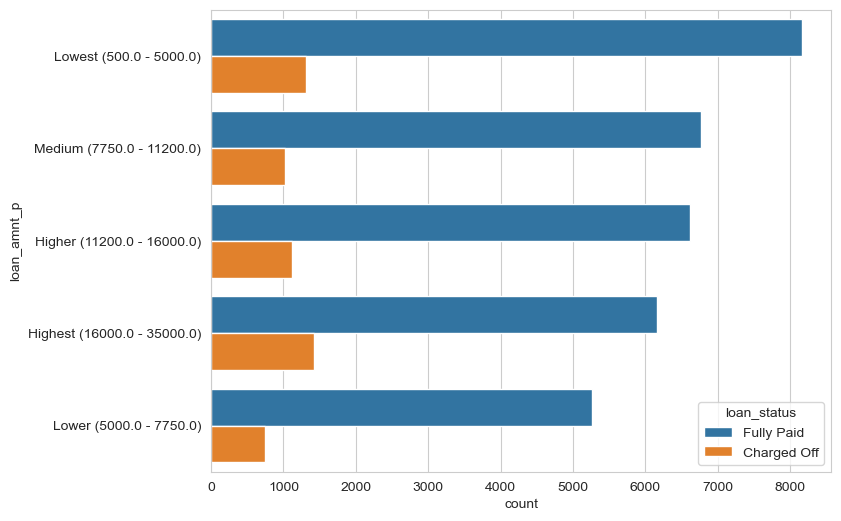

loan_amnt_p,Charged off %,Record count
Highest (16000.0 - 35000.0),0.187624,7579
Higher (11200.0 - 16000.0),0.145368,7739
Lowest (500.0 - 5000.0),0.138725,9472
Medium (7750.0 - 11200.0),0.131613,7788
Lower (5000.0 - 7750.0),0.123521,5999


In [125]:
PercentileCut(column='loan_amnt')
Univariate_Categorical(column='loan_amnt_p')

Higher the loan amount, greater the chance of the loan getting default.
____

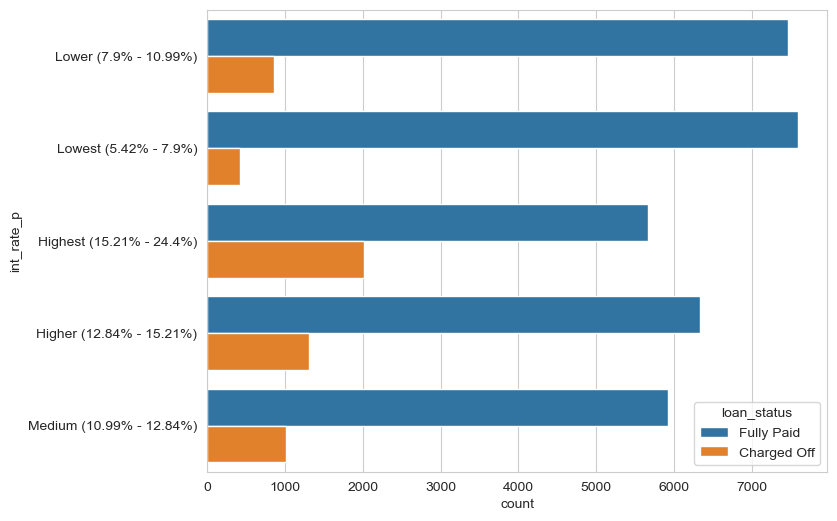

int_rate_p,Charged off %,Record count
Highest (15.21% - 24.4%),0.262150,7675
Higher (12.84% - 15.21%),0.171619,7639
Medium (10.99% - 12.84%),0.146995,6939
Lower (7.9% - 10.99%),0.102876,8311
Lowest (5.42% - 7.9%),0.053538,8013


In [126]:
PercentileCut(column='int_rate', trailer='%')
Univariate_Categorical(column='int_rate_p')

Higher the interest rate leads to higher charged off%

---

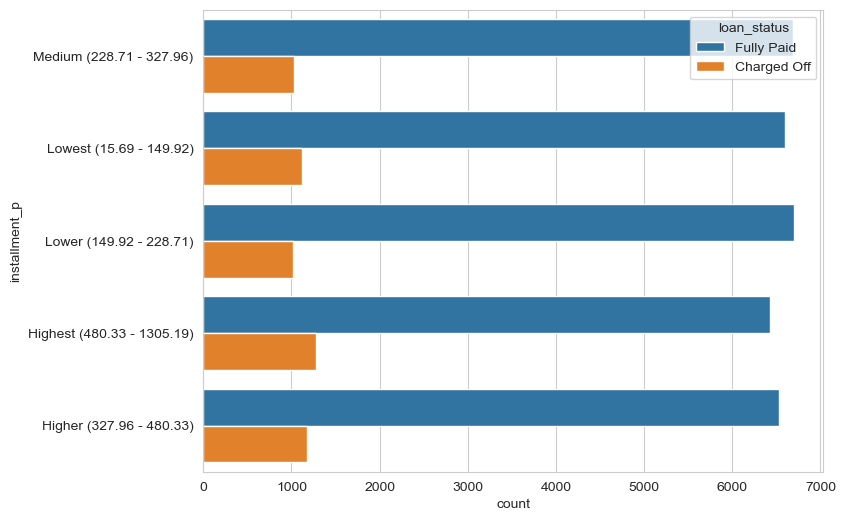

installment_p,Charged off %,Record count
Highest (480.33 - 1305.19),0.166321,7714
Higher (327.96 - 480.33),0.152988,7713
Lowest (15.69 - 149.92),0.145153,7716
Medium (228.71 - 327.96),0.132936,7718
Lower (149.92 - 228.71),0.131934,7716


In [127]:
PercentileCut(column='installment')
Univariate_Categorical(column='installment_p')

Above data and plot shows that higher installment amounts shows higher default percentages.

---

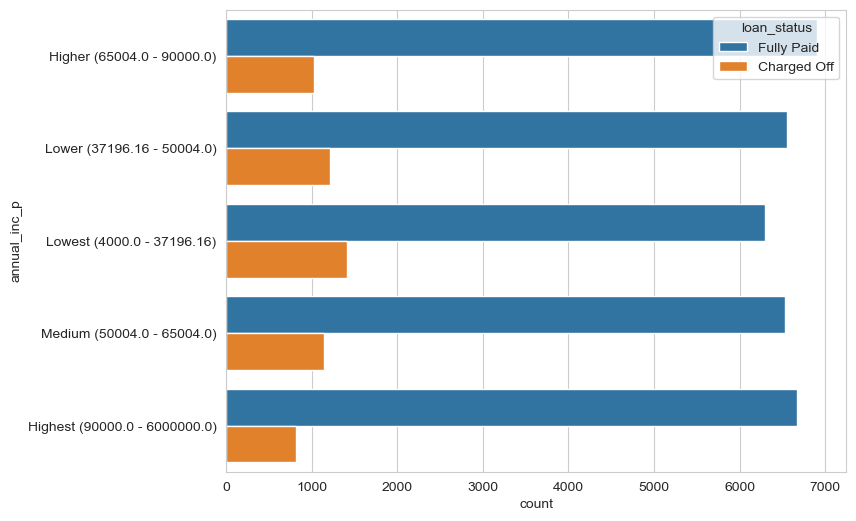

annual_inc_p,Charged off %,Record count
Lowest (4000.0 - 37196.16),0.183126,7716
Lower (37196.16 - 50004.0),0.156926,7768
Medium (50004.0 - 65004.0),0.149629,7679
Higher (65004.0 - 90000.0),0.129651,7929
Highest (90000.0 - 6000000.0),0.109285,7485


In [128]:
PercentileCut(column='annual_inc')
Univariate_Categorical(column='annual_inc_p')

Higher the income hiegher the repayment %

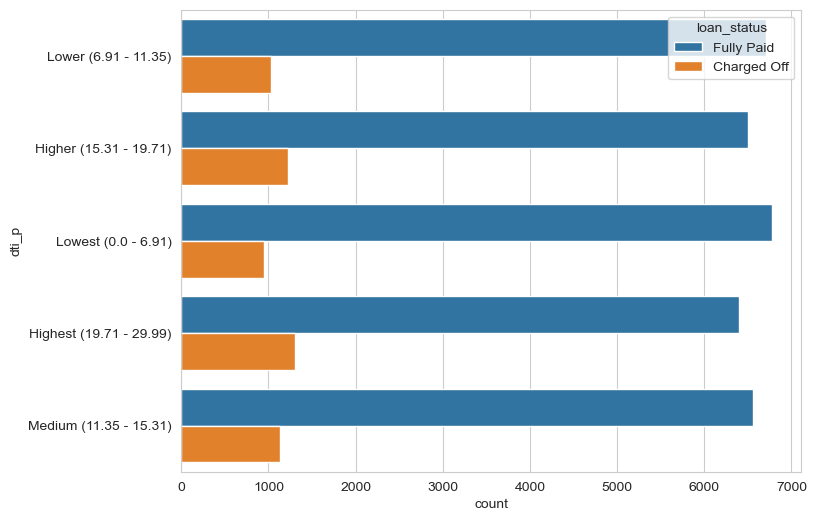

dti_p,Charged off %,Record count
Highest (19.71 - 29.99),0.168853,7699
Higher (15.31 - 19.71),0.157908,7726
Medium (11.35 - 15.31),0.147609,7696
Lower (6.91 - 11.35),0.132627,7736
Lowest (0.0 - 6.91),0.122409,7720


In [129]:
PercentileCut(column='dti')
Univariate_Categorical(column='dti_p')

higher DTI ( debt to income ratio) will lead to higher charged off %

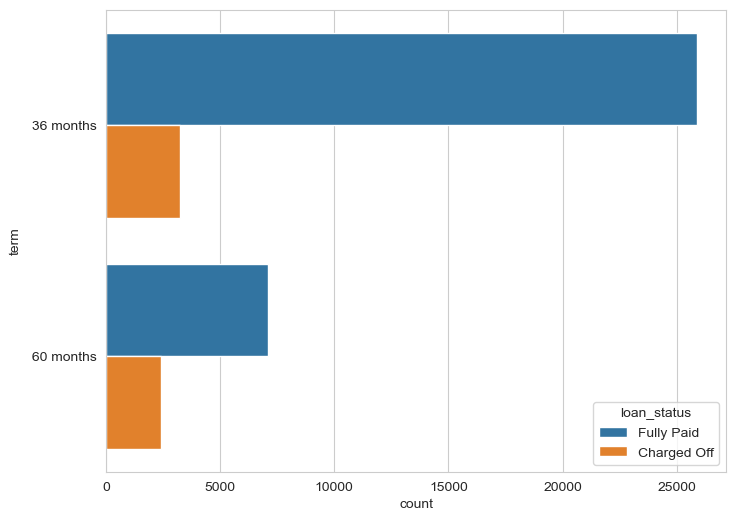

term,Charged off %,Record count
60 months,0.253138,9481
36 months,0.110909,29096


In [130]:
Univariate_Categorical(column='term')

For loans with 5 year repayment term, the default percent is 25%. And for 3 year loan repayment term, the default is only for 11% of the cases. 
Therefore, loan repayment term plays a factor in judging the default rate.

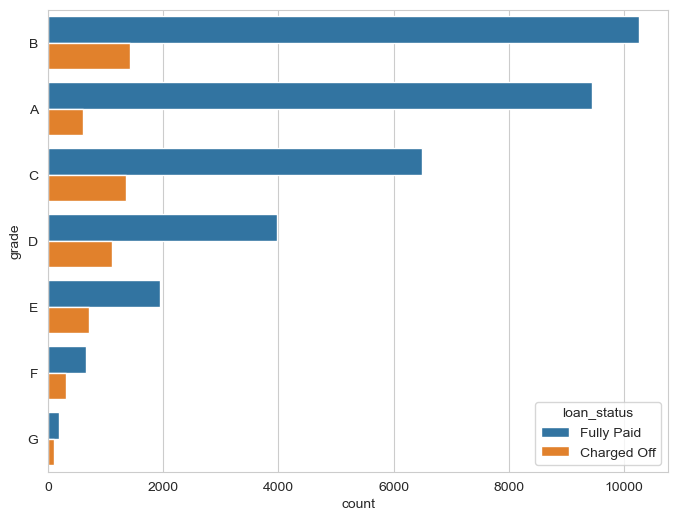

grade,Charged off %,Record count
G,0.337793,299
F,0.326844,976
E,0.268494,2663
D,0.219862,5085
C,0.171943,7834
B,0.122056,11675
A,0.059930,10045


In [131]:
Univariate_Categorical(column='grade')

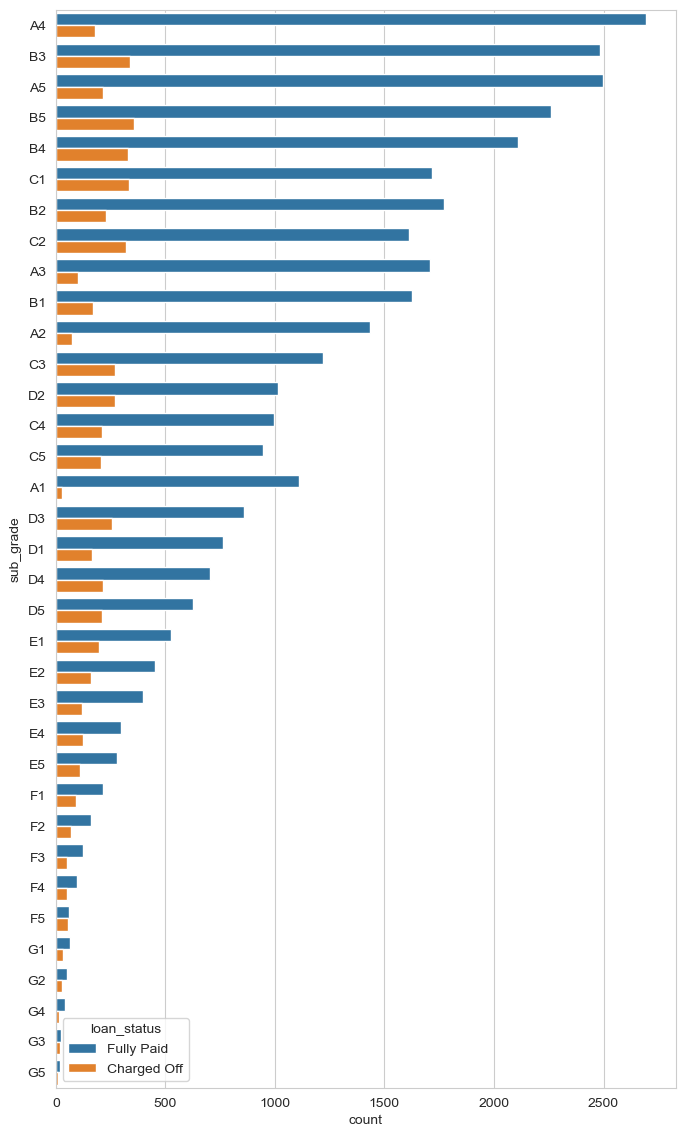

sub_grade,Charged off %,Record count
F5,0.477876,113
G3,0.422222,45
G2,0.363636,77
F4,0.350993,151
G5,0.344828,29
G1,0.329787,94
F2,0.300429,233
F1,0.298361,305
E4,0.297170,424
F3,0.293103,174


In [132]:
Univariate_Categorical(column='sub_grade', figsize=(8,14))

The above table shows the loan sub-grade versus the default percentage. The G3 and F5 sub categories have above 40% default rate. This field is a clear indicator of the default percent.

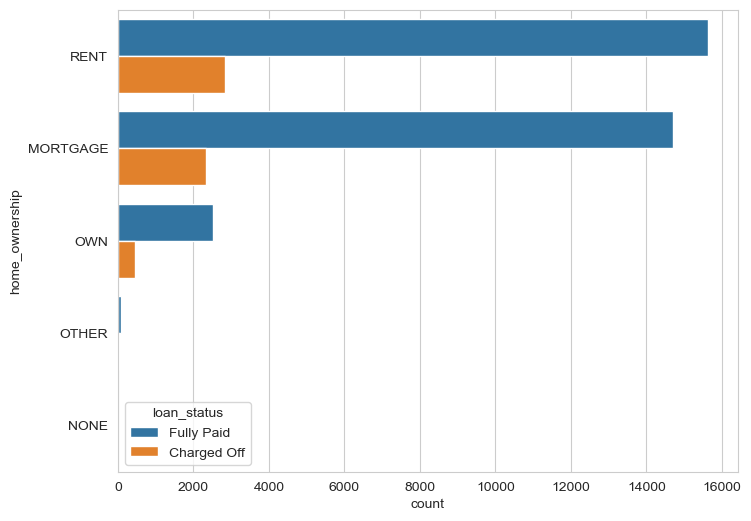

home_ownership,Charged off %,Record count
OTHER,0.183673,98
RENT,0.153626,18480
OWN,0.148908,2975
MORTGAGE,0.136713,17021


In [133]:
Univariate_Categorical(column='home_ownership')

we have not much info to conclude as it says "OTHER"

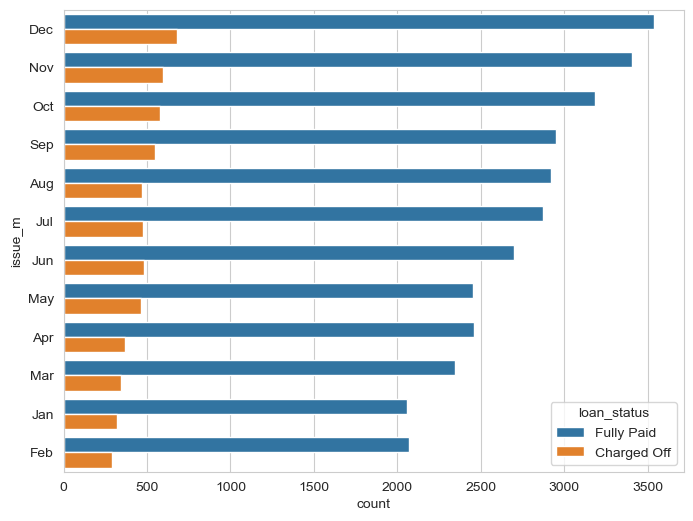

issue_m,Charged off %,Record count
Dec,0.160854,4215
May,0.159644,2919
Sep,0.156375,3498
Oct,0.154214,3761
Jun,0.151887,3180
Nov,0.149276,4006
Jul,0.142942,3351
Aug,0.138135,3388
Jan,0.134931,2379
Apr,0.130696,2831


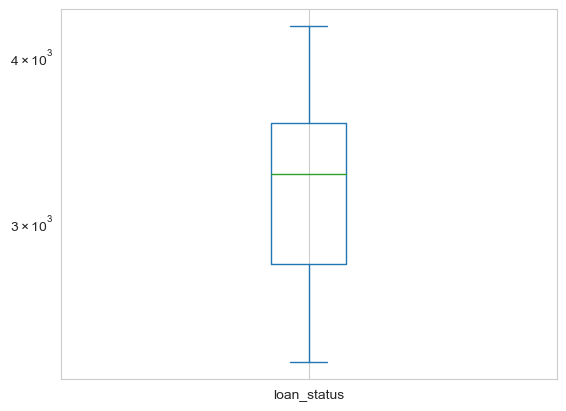

In [134]:
Univariate_Categorical(column='issue_m', box_plot=True)

December is the month which has the highest number of loan applications per year and also have the biggest default ratio. 
The next ine is May 
This correlates with Christmas and summer break US where people are in celebration mood and tend to spend more.

### Bivariate Analysis

Now that we have analyzed each of the variables and its impact on the loan-status, let us take group of variables together and and analyze their combined effect on the loan-status. These categories are based on our business understanding. The original distribution column shows the average trend in all the data and we compare that with the data after applying our conditions.

In [135]:
def Bivariate_Analysis (*, data=loan_df, x, y, title=None, by='loan_status', figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, one numerical and one categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a violin plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=data, x=x, y=y, hue=by, split=True, figsize=figsize,
                   ax=ax)
    if title is not None:
        plt.title(title)
    plt.show()

In [136]:
def Bivariate_Categorical (*, data=loan_df, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    pt = pd.pivot_table(data=data, values='loan_status_num', index=y, columns=x)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

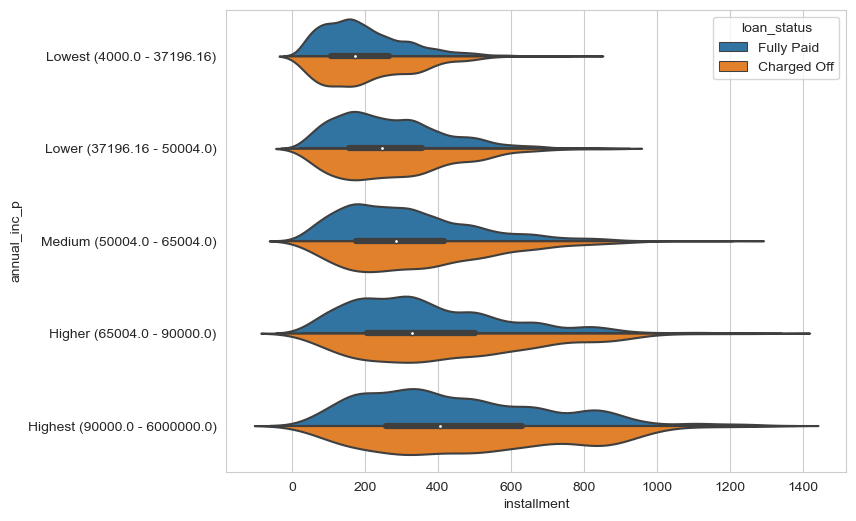

In [137]:
Bivariate_Analysis(x='installment', y='annual_inc_p')
plt.show()

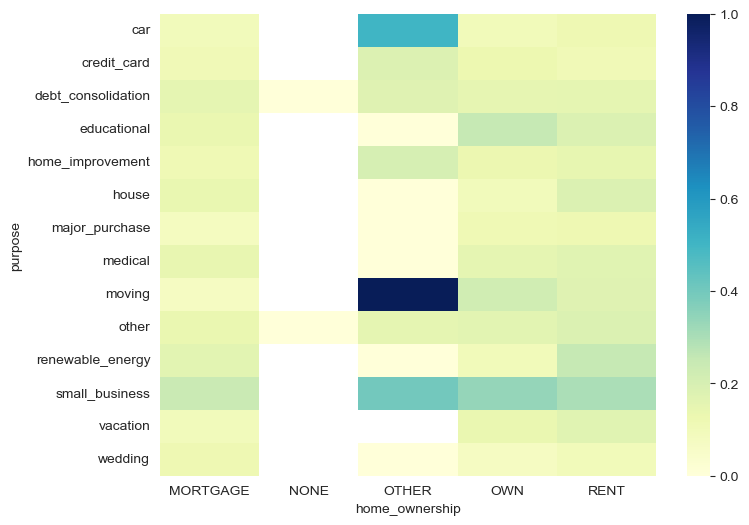

In [138]:
Bivariate_Categorical(x='home_ownership', y='purpose')

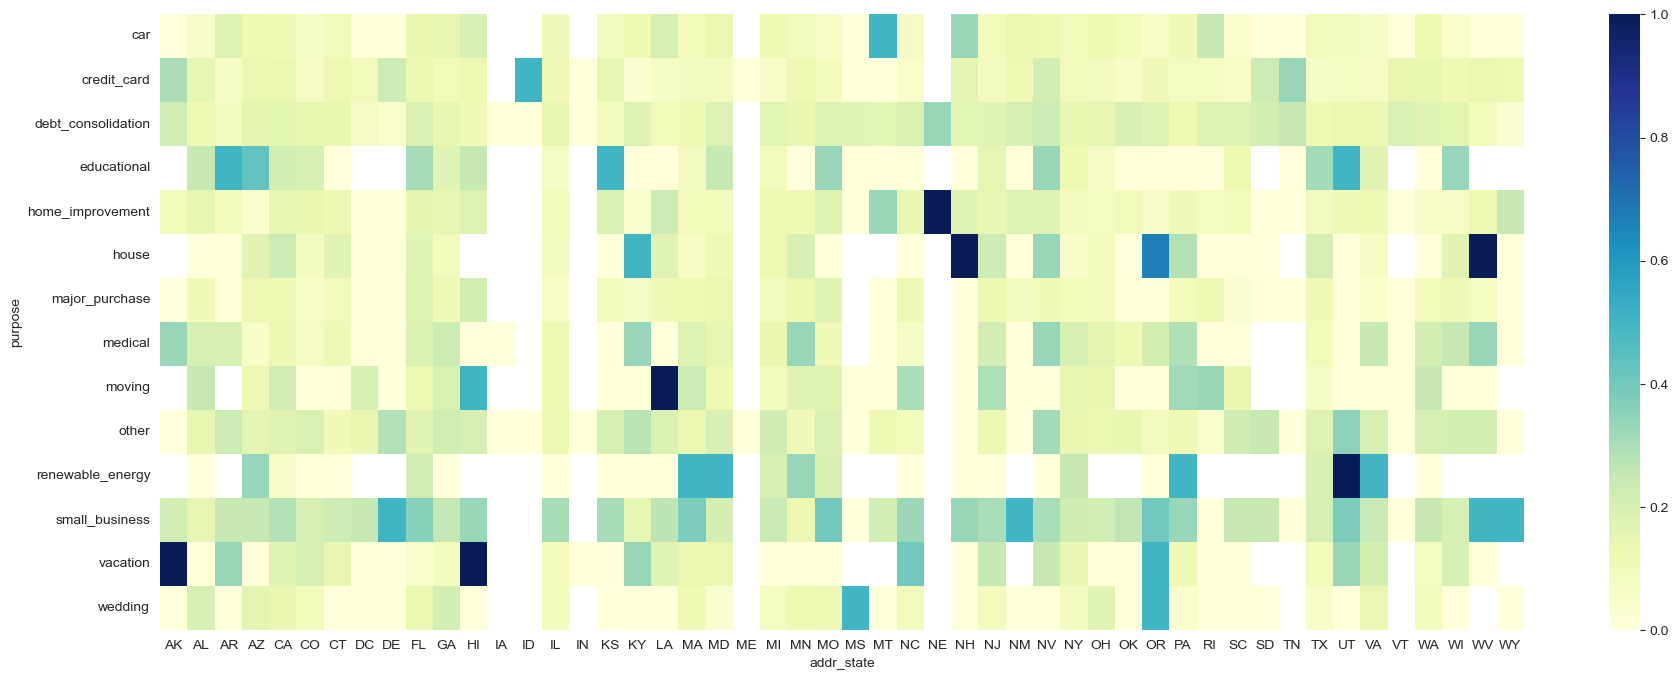

In [139]:
Bivariate_Categorical(x='addr_state', y='purpose', figsize=(22,8))

As per the above plot, the darker the intersection of addr_state has with the purpose of the loan, the risker the loan application is. Some of the examples are below:
 - vacation loans in AK, HI, OR
 - education loans in AR, KS, UT
 - small business loans in DE, NM, WV, wY
 - wedding loans in MS, OR

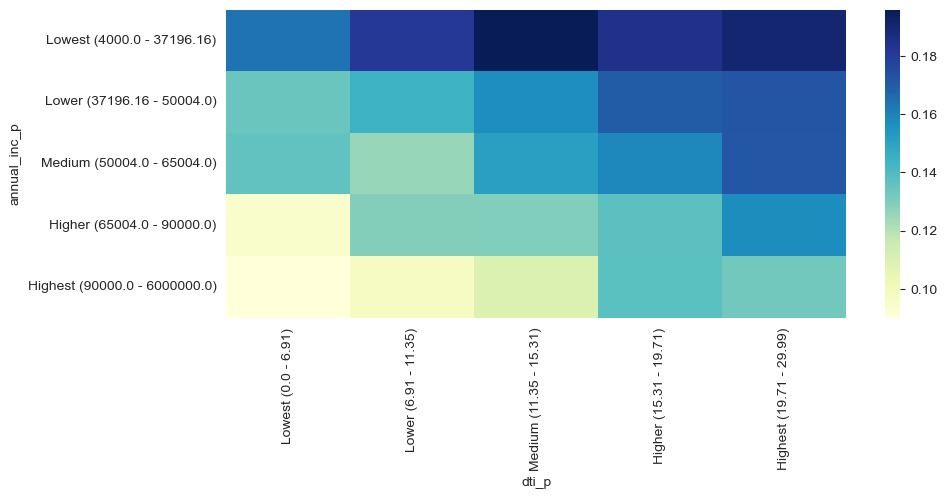

In [140]:
Bivariate_Categorical(x='dti_p', y='annual_inc_p', figsize=(10,4))

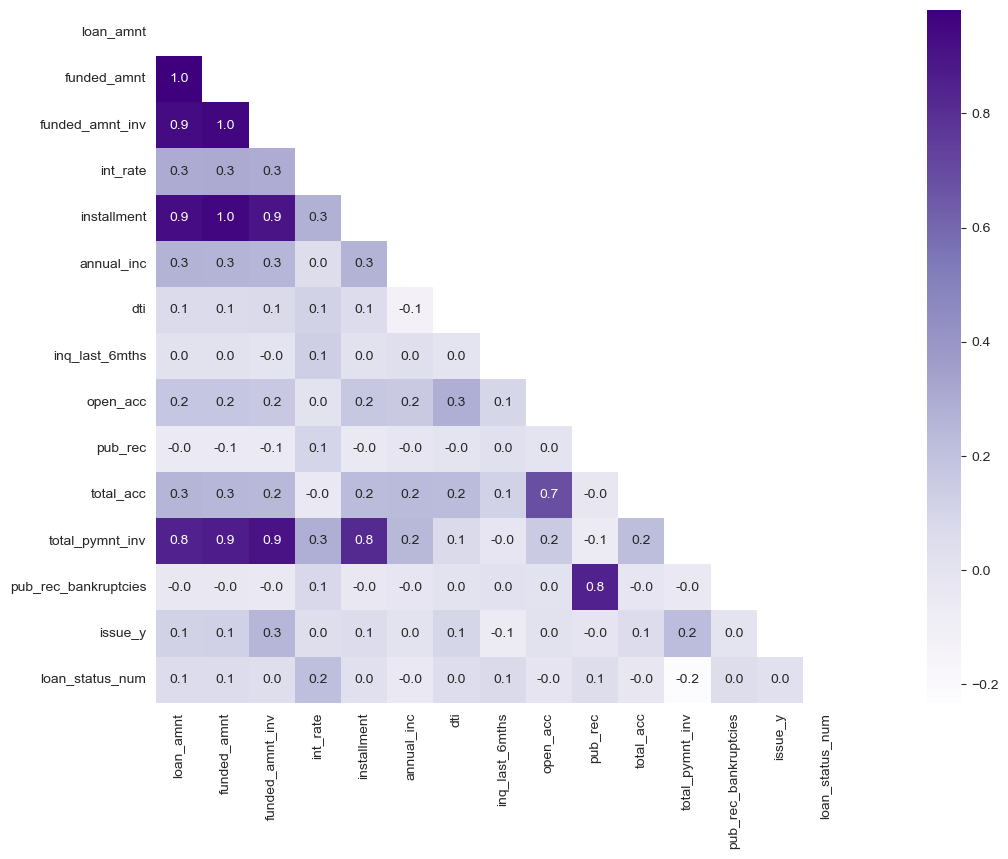

In [143]:
# Creating a correlation heatmap
plt.figure(figsize=(20,9))
correlation = loan_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt = '.1f', mask=mask, square=True, cmap='Purples')
plt.show()

Medium debt-to-income group in the lowest income range is the most risky when it comes to loan repayment.

 Hereby we come to an end of the EDA of the loan data set and finding some of the drivers for loan default. Apart from the ones highlighted below, I am sure there will be multiple others too; however, according to me, these are the most impactful ones.

<b>Minor Impact</b> <br>
.Higher loan amount (above 16K) <br>
•Higher installment amount (above 327) <br>
•Lower annual income (below 37K)<br> 
•Higher debt to income ratio (above 15%) <br>
•Applicant’s address state (NV, SD, AK, FL, etc.) <br>
•Loan issue month (Dec, May, Sep)<br>

<b>Heavy impact</b> <br>
•Higher interest rate (above 13%) <br>
•Higher revolving line utilization rate (above 58%) <br>
•Repayment term (5 years)<br> 
•Loan grade & sub-grade (D to G) <br>
•Missing employment record<br> 
•Loan purpose (small business, renewable energy, educational) <br>
•Derogatory public records (1 or 2) <br>
•Public bankruptcy records (1 or 2)<br>

<b>Combined impact</b> <br>
•High loan amount & interest rate for lower income group <br>
•High installment and longer repayment term <br>
•Home ownership (other) and loan purpose (car, moving or small business) <br>
•Residential state and loan purpose<br> 
•Income group and loan purpose<br>